In [108]:
import scanpy as sc
from sklearn.cluster import KMeans
from utils.evaluate import evaluate_clustering

In [109]:
adata = sc.read("../data/Tosches_turtle_processed.h5ad")

In [ ]:
# -----------------------------
# 1) PCA
# -----------------------------
# 若 adata.X 已经是 log1p 后的表达矩阵（常见做法），可以直接 PCA
# 这里 n_comps 通常设 50 左右
sc.tl.pca(adata, n_comps=50, use_highly_variable=False, svd_solver="arpack")

# 可选：看看 PCA 方差解释度
# sc.pl.pca_variance_ratio(adata, log=True)

# -----------------------------
# 2) KNN 图（neighbors）
# -----------------------------
# n_neighbors 常用 10~30；数据 18k 细胞，建议先用 15 或 20 起步
# n_pcs 使用多少个主成分构建图：常用 30~50
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=30,
    metric="cosine"   # 常用 'cosine' 或 'euclidean'；cosine 在 scRNA 上很常见
)

/data/sjy/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


In [134]:
# -----------------------------
# 3) Leiden 聚类
# -----------------------------
# resolution 越大，簇越多；建议从 0.5~1.5 扫一下
sc.tl.leiden(
    adata,
    resolution=1.0,
    key_added="leiden"  # 聚类结果存到 adata.obs['leiden']
)

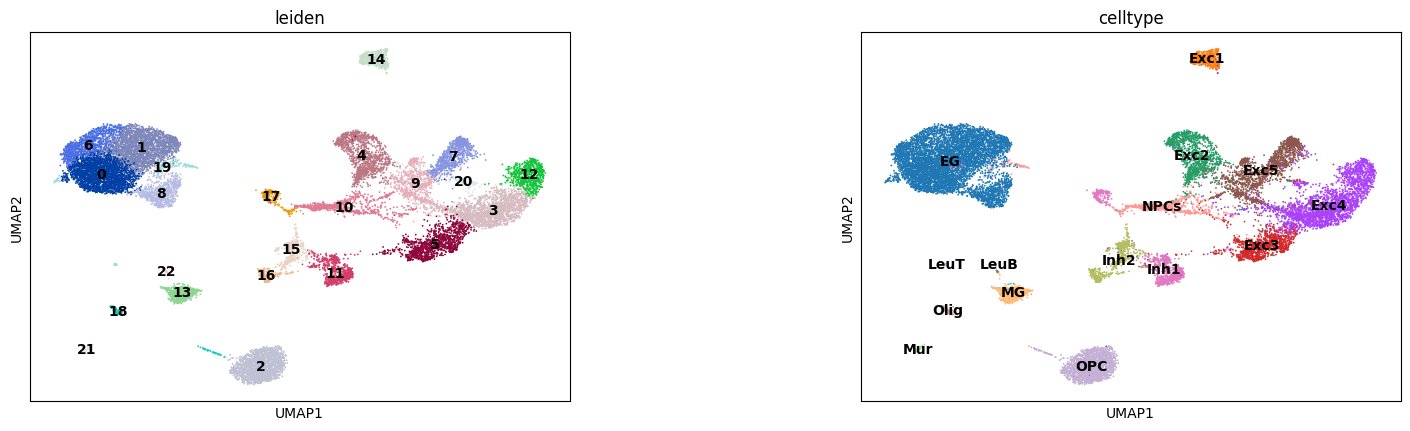

In [135]:
# -----------------------------
# 4) (推荐) UMAP 可视化
# -----------------------------
sc.tl.umap(adata, min_dist=0.3, spread=1.0)

# 同时绘制：Leiden 聚类结果 + ground-truth celltype
sc.pl.umap(
    adata,
    color=["leiden", "celltype"],
    legend_loc="on data",      # 如果 celltype 太多，建议改成 'right margin'
    wspace=0.4
)

In [136]:
cluster_labels = adata.obs['leiden'].to_list()
true_labels = adata.obs['celltype'].to_list()

print(len(cluster_labels), len(true_labels))

18301 18301


In [137]:
eval_result = evaluate_clustering(cluster_labels, true_labels)
print(eval_result)

{'NMI': 0.7752060443447104, 'ARI': 0.5044871746518542, 'ACC': 0.6325883831484619}


In [138]:
raise SystemExit

SystemExit: 

/data/sjy/anaconda3/envs/scrna/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# k-means
# -----------------------------
# 1) PCA
# -----------------------------
# sc.tl.pca(adata, n_comps=50, use_highly_variable=False, svd_solver="arpack")

# 取 PCA 矩阵（cells x PCs）
X_pca = adata.obsm["X_pca"]  # numpy array

# -----------------------------
# 2) K-means 聚类（在 PCA 空间）
# -----------------------------
# 你需要指定簇数 k。常见做法：k = 真实 celltype 的类别数，或你想要的簇数
# 例如：k = adata.obs["celltype"].nunique()  (如果你想对齐 ground-truth 的类别数)
k = int(adata.obs["celltype"].nunique()) if "celltype" in adata.obs.columns else 10

kmeans = KMeans(
    n_clusters=k,
    n_init=50,        # 多次初始化更稳
    random_state=0
)
kmeans_labels = kmeans.fit_predict(X_pca[:, :30])  # 用前 30 个PC，按需改成 20/50

# 存到 obs（和 leiden 类似）
adata.obs["kmeans"] = kmeans_labels.astype(str)  # 存字符串，便于画图/对比
adata.obs["kmeans"] = adata.obs["kmeans"].astype("category")

In [ ]:
# -----------------------------
# 3) (推荐) UMAP 可视化
# -----------------------------
# UMAP 仍然需要 neighbors 图来跑（只是为了可视化）
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, metric="cosine")
sc.tl.umap(adata, random_state=0)

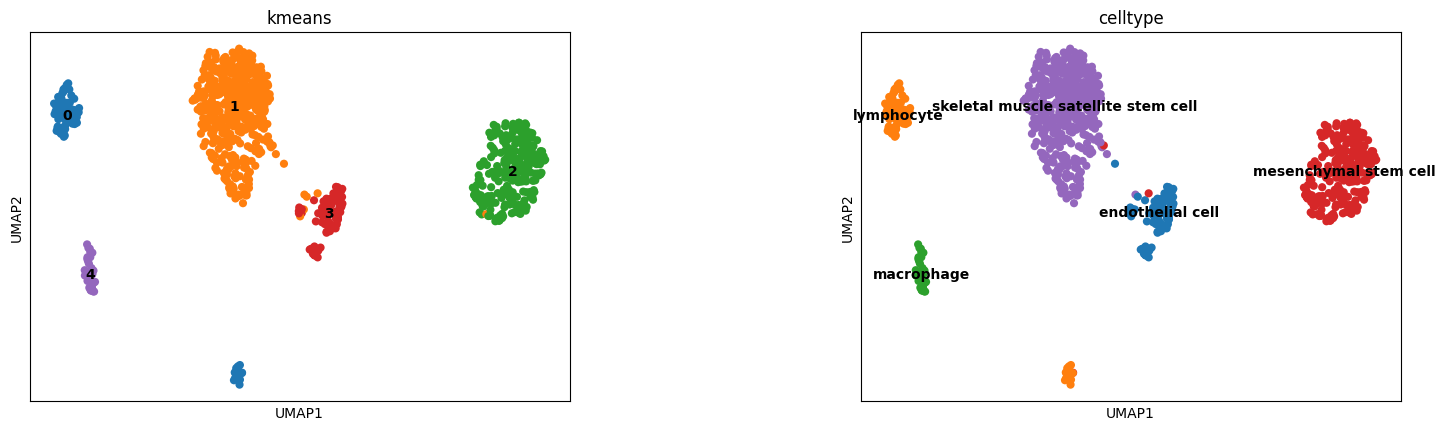

In [ ]:
# 同时画：kmeans 结果 + ground-truth
plot_cols = ["kmeans"]
if "celltype" in adata.obs.columns:
    adata.obs["celltype"] = adata.obs["celltype"].astype("category")
    plot_cols.append("celltype")

sc.pl.umap(adata, color=plot_cols, legend_loc="on data", wspace=0.4)

In [ ]:
# -----------------------------
# 4) 取出标签列表（用于 NMI/ARI/ACC）
# -----------------------------
cluster_labels = adata.obs["kmeans"].astype(str).tolist()
true_labels = adata.obs["celltype"].astype(str).tolist() if "celltype" in adata.obs.columns else None

print("n_cells:", len(cluster_labels))
print("cluster head:", cluster_labels[:5])
if true_labels is not None:
    print("true head:", true_labels[:5])
    
evaluate_clustering(cluster_labels, true_labels)

n_cells: 870
cluster head: ['1', '2', '2', '3', '3']
true head: ['skeletal muscle satellite stem cell', 'mesenchymal stem cell', 'mesenchymal stem cell', 'endothelial cell', 'endothelial cell']


{'NMI': 0.9611784128681269,
 'ARI': 0.9743809600081471,
 'ACC': 0.9908045977011494}